In [1]:
import flopy, os, fiona, time, sys, rasterio, shutil
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from osgeo import gdal, ogr, osr

In [2]:
ws = 'Yauca'

In [3]:
basinEPSG = {'Yauca':32718,
            'Camana':32718,
            'Ocona':32718,
            'Quilca':32719,
            'Tambo':32719}

In [6]:
Path = '/mnt/c/Users/lrbk/Documents/CSM/Proyects/5_Watershed'
basePath = os.path.join(Path,'5_watershedDelineation','1_Outputs',F'{ws}')
auxPath = F'../data'
gisPath =os.path.join(Path,'2_GIS','2_Processed',F'{ws}')


# 1. Loading hrus

In [7]:
# Hrus are landuses

luPath = os.path.join(basePath,'landuses.gpkg')
lu = gpd.read_file(luPath)

nhru = lu.shape[0]

# Adding a numeric identifier

lu['id'] = range(nhru)
lu['hru_type'] = np.ones(nhru)

<AxesSubplot:>

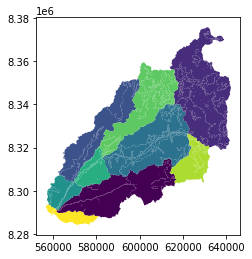

In [14]:
lu.plot(column='basin',cmap='viridis')

# 2. Properties

In [17]:
# # #Adding reservoir
# # resFile = os.path.join(gisPath,F'basin{ws}.gpkg')
# # res = gpd.read_file(resFile,layer='reservoir')
# # lu = lu.overlay(res, how='difference')
# # lu.loc[nhru] = [11,'reservoir',40.0,'Pasto grande',res.geometry.item(),nhru,2]

# np.savetxt(os.path.join(auxPath,'hru_type.dat'),lu['hru_type'].values)

# nhru = lu.shape[0]

# # lu = lu.sort_values('basin_idx')
# # lu = lu.reset_index(drop=True)

In [18]:
# Creating centroids

lu['centroid'] = lu.centroid
lu['x'] = lu.centroid.x.values
lu['y'] = lu.centroid.y.values

# Area
lu['area'] = lu.area

In [19]:
# Latitude, longitude

lu_wgs84 = lu.copy()
lu_wgs84 = lu_wgs84.set_crs(basinEPSG[ws])
lu_wgs84 = lu_wgs84.to_crs(4326)
lu['centroid_wgs84'] = lu_wgs84.centroid
lu['lat'] = lu['centroid_wgs84'].y
lu['lon'] = lu['centroid_wgs84'].x

/tmp/ipykernel_467/3295635787.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lu['centroid_wgs84'] = lu_wgs84.centroid


In [22]:
# Elevation, aspect, slope

demPath = os.path.join(gisPath,F'dem{ws}.tiff')
slopePath = os.path.join(gisPath,F'slope{ws}.tiff')
aspectPath = os.path.join(gisPath,F'aspect{ws}.tiff')
# Generating Slope
slope_opts = gdal.DEMProcessingOptions(slopeFormat='percent')
slope = gdal.DEMProcessing(slopePath, demPath, 'slope',options=slope_opts) # ,options=slope_opts
slope = None
# Generating Aspect
aspect_opts = gdal.DEMProcessingOptions(trigonometric=True,zeroForFlat=True) # Trigonometric makes east = 0 degrees, flat to make -9999 equal to 0
aspect = gdal.DEMProcessing(aspectPath, demPath, 'aspect',options=aspect_opts) # ,options=aspect_opts
aspect = None

# Sampling
coord_list = [(x,y) for x,y in zip(lu['centroid'].x , lu['centroid'].y)]

srcDem = rasterio.open(demPath)
srcSlo = rasterio.open(slopePath)
srcAsp = rasterio.open(aspectPath)

lu['elev'] = [int(x) for x in srcDem.sample(coord_list)]
lu['slope'] = [round(x.item()) for x in srcSlo.sample(coord_list)]
lu['aspect'] = [round(x.item()) for x in srcAsp.sample(coord_list)]

srcDem = None
srcSlo = None
srcAsp = None

# Correcting slope

lu['slope'] = lu['slope']/100
lu['slope'][lu['slope'] < 0] = 0
lu['slope'][lu['slope'] > 10] = 10

/tmp/ipykernel_467/3964997323.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lu['slope'][lu['slope'] < 0] = 0
/tmp/ipykernel_467/3964997323.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lu['slope'][lu['slope'] > 10] = 10


In [24]:
# Soil type

soilPath = os.path.join(gisPath,'soilType.tiff')
srcSoil = rasterio.open(soilPath)
lu['soil_type'] = [int(x) for x in srcSoil.sample(coord_list)]
srcSoil = None

In [26]:
# Defining zones/subbasins

lu['zones'] = 999 # int
zones=dict((j,i+1) for i,j in enumerate(lu.basin.unique()))    
for idx,row in lu.iterrows():
     lu.loc[idx,'zones'] = zones[row.basin]
# lu.loc[lu['landuse'] == 'reservoir','zones']= lu.zones.max()+1 # Fixing reservoir zone as a different one
lu.zones.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [35]:
# Cover type
cov_type = {0:['barren','water','mining','urban','glacier','reservoir'], # bare soil
            1:['crops','grassland','wetland'], # grasses
            2:['shurbland'], # shrubs
            3:['woodland']} # trees # 4:coniferous # no coniferous
lu['cov_type'] = 0
for idx,row in lu.iterrows():
    for key in cov_type.keys():
        if row.landuse in cov_type[key]:
            lu.loc[idx,'cov_type'] = key

# covden_sum covden_win
covden_sum = {0:0,1:0.4,2:0.5,3:0.6} # related to cov_type
lu['covden_sum'] = 0.1
for idx,row in lu.iterrows():
    lu.loc[idx,'covden_sum'] = covden_sum[row.cov_type]

# covden_sum covden_win
covden_win = {0:0,1:0.3,2:0.4,3:0.5} # related to cov_type
lu['covden_win'] = 0.1
for idx,row in lu.iterrows():
    lu.loc[idx,'covden_win'] = covden_win[row.cov_type]

# Correcting for crops
lu.loc[lu.landuse=='crops','covden_sum'] = 0.9
lu.loc[lu.landuse=='crops','covden_win'] = 0.9

In [42]:
# impervious
lu['percent_imperv'] = 0.0
impervPath = os.path.join(gisPath,F'imperv{ws}.gpkg')
imperv = gpd.read_file(impervPath)
for idx,rowL in lu.iterrows():
    impClip = gpd.clip(imperv,rowL.geometry)
    if impClip.shape[0]>0: # if there is imperv zones in the hru
        lu.loc[idx,'percent_imperv'] = impClip.unary_union.area/rowL.area
    else:
        lu.loc[idx,'percent_imperv'] = 0
lu['percent_imperv'][lu.percent_imperv>0.99] = 0.99
lu['percent_imperv'][lu.percent_imperv<0.01] = 0

/tmp/ipykernel_467/2331316228.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lu['percent_imperv'][lu.percent_imperv>0.99] = 0.99
/tmp/ipykernel_467/2331316228.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lu['percent_imperv'][lu.percent_imperv<0.01] = 0


In [44]:
# Formating not used geometries
lu.centroid = lu.centroid.astype('str')
lu.centroid_wgs84 = lu.centroid_wgs84.astype('str')

In [45]:
# Exporting

outPath = os.path.join(auxPath,F"{ws}.gpkg")
lu.to_file(outPath, layer=ws, driver="GPKG")